## Topic Modelling for Work Advice Reddit Posts

Walker A., Wen Yi A., Ken M.

We will be using LDA (Latent Dirichlet Allocation) to help figure what kinds of posts are being discussed in these spaces. First we will read in the submissions collected from Reddit related to career/work advice. This dataset was previously collected in Phase 1 of the project

In [1]:
# general imports
import pandas as pd
import numpy as np
# cleaning imports
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# LDA/Vectorizer imports
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pyLDAvis

Reading in our data:

In [2]:
# First we will read in our ~4000 posts:
data = pd.read_csv('postdata_full.csv')
print(data.shape)
data.head()

(3997, 11)


,Unnamed: 0,subreddit,title,id,author,text,num_comments,score,upvote_ratio,flair,distinguished
0,0,careerguidance,Anyone else’s coworkers suddenly quitting with...,qv8jc4,Pugnastyornah,Our 3rd coworker in less than 2 months quit Fr...,358,1309,0.99,Coworkers,NaN
1,1,careerguidance,I have only been working Full-Time for 5 years...,ojgq1c,Archprimus_,I don't understand what is wrong with me. When...,231,1012,0.98,NaN,NaN
2,2,careerguidance,"Lied about getting another offer, hr wants to ...",sdnh5m,ten_choe,"So for the last three months, I took over my b...",347,950,0.98,Advice,NaN
3,3,careerguidance,Anyone else have the feeling their job is bull...,o1xcex,Suitable-Excitement3,Just looking to vent incase anyone else here h...,279,921,0.99,Advice,NaN
4,4,careerguidance,How many of y'all have gotten so burnt out tha...,u62d2x,rodtrusty,I'm an Executive Chef and I'm struggling with ...,278,899,0.99,NaN,NaN


The dataset we are using contains 3997 submissions across 4 career and work advice related subreddits. This dataset is expanded from that of the 500 submissions in Phase 1. This was done to ensure we had enough data to topic model effectively.

Looking at the data head, there is a repeat index column (Unnamed: 0) that we can drop. The other columns include the Title of the Post, the subreddit the post was in, the id of the post, the author name, the actual body text of the submission, and other features (num_comments, score, upvote_ratio, flair, distinguished). 

In [3]:
# our data has an unnecessary column: Unnamed:0. Let's drop it:
data = data.drop(['Unnamed: 0'], axis = 1)
data.head()

,subreddit,title,id,author,text,num_comments,score,upvote_ratio,flair,distinguished
0,careerguidance,Anyone else’s coworkers suddenly quitting with...,qv8jc4,Pugnastyornah,Our 3rd coworker in less than 2 months quit Fr...,358,1309,0.99,Coworkers,NaN
1,careerguidance,I have only been working Full-Time for 5 years...,ojgq1c,Archprimus_,I don't understand what is wrong with me. When...,231,1012,0.98,NaN,NaN
2,careerguidance,"Lied about getting another offer, hr wants to ...",sdnh5m,ten_choe,"So for the last three months, I took over my b...",347,950,0.98,Advice,NaN
3,careerguidance,Anyone else have the feeling their job is bull...,o1xcex,Suitable-Excitement3,Just looking to vent incase anyone else here h...,279,921,0.99,Advice,NaN
4,careerguidance,How many of y'all have gotten so burnt out tha...,u62d2x,rodtrusty,I'm an Executive Chef and I'm struggling with ...,278,899,0.99,NaN,NaN


For our posts, we want to include the title text, in addition to title body. This was chosen since after some initial runs, we realized that a lot of key words and meaning existed in the Titles. Only using the body text loses some context. Moreover in social media, especially Reddit, a lot of people use titles as a 'TLDR' or a 'hook' to get people invested and convey the main aspect of the post. So as part of pre-processing we will create a new column that has the title and body texts together.

In [4]:
# we will only be using the 'text', so lets retrieve the series,
# but lets also add title since that contains valuable information:
data['transcript'] = [str(data.title[i]) + " " + str(data.text[i]) for i in range(data.shape[0])]
data.head()

,subreddit,title,id,author,text,num_comments,score,upvote_ratio,flair,distinguished,transcript
0,careerguidance,Anyone else’s coworkers suddenly quitting with...,qv8jc4,Pugnastyornah,Our 3rd coworker in less than 2 months quit Fr...,358,1309,0.99,Coworkers,NaN,Anyone else’s coworkers suddenly quitting with...
1,careerguidance,I have only been working Full-Time for 5 years...,ojgq1c,Archprimus_,I don't understand what is wrong with me. When...,231,1012,0.98,NaN,NaN,I have only been working Full-Time for 5 years...
2,careerguidance,"Lied about getting another offer, hr wants to ...",sdnh5m,ten_choe,"So for the last three months, I took over my b...",347,950,0.98,Advice,NaN,"Lied about getting another offer, hr wants to ..."
3,careerguidance,Anyone else have the feeling their job is bull...,o1xcex,Suitable-Excitement3,Just looking to vent incase anyone else here h...,279,921,0.99,Advice,NaN,Anyone else have the feeling their job is bull...
4,careerguidance,How many of y'all have gotten so burnt out tha...,u62d2x,rodtrusty,I'm an Executive Chef and I'm struggling with ...,278,899,0.99,NaN,NaN,How many of y'all have gotten so burnt out tha...


Now we have a new column 'Transcript' that contains both the body text and title of our reddit posts. This is valuable since in Reddit, a lot of vital information is contained in the title in addition to the text. We want to include both.

In [5]:
# isolating the series of interest
data = data.transcript

# dropping missing values
data_clean = data.dropna()
len(data_clean)

3997

We can see that there are no missing data points. Before we clean our data we can see how our text looks like:

In [6]:
data_clean.head()

0    Anyone else’s coworkers suddenly quitting with...
1    I have only been working Full-Time for 5 years...
2    Lied about getting another offer, hr wants to ...
3    Anyone else have the feeling their job is bull...
4    How many of y'all have gotten so burnt out tha...
Name: transcript, dtype: object

In [7]:
# closer look at first element
data_clean[0]

'Anyone else’s coworkers suddenly quitting with no job lined up? Our 3rd coworker in less than 2 months quit Friday. I asked him what’s next and he said “the sun and the sky”. The other coworkers also didn’t have a job lined up yet. \n\nIt’s interesting because my boss just a couple months ago was threatening to fire me, partially citing that we were fully staffed, and now we’re short staffed and she’s changed her tune with me. I’m also a full time graduate student so if I quit, I’d be just fine between student loans and landing an assistantship/ part time gig. \n\nThis great resignation movement seems to be the real deal. Unemployment data is being released on Friday and I’m very curious of the results.\n\nThere needs to be a “Great Resignation” flair on this sub lol\n\nEdit: since I’ve posted this, another coworker quit… 4 coworkers in just at 3 months now. Small office. This particular coworker started less than 2 months ago.'

### Cleaning:

Before we vectorize our texts and use LDA topic modelling, we have to make sure our texts are clean. We can use the the text above as an example of what to maintain and what to clean. We can see capitalized letters, and punctuations. We will have to lower our text and remove punctuations. We can also see new line (\n) symbols. We also see numbers. In this case, we are choosing to keep numbers because in a work setting numbers have important value. For example, it could be related to salary advice, or even specific work forms/savings (401K). Let's do some text cleaning:

In [8]:
# converting all text to lowercase
data_clean = data_clean.str.lower()
# replace all non-alphanumeric symbols:
data_clean = data_clean.str.replace(r"[^\w\s]", "", regex=True)
# removing new line symbols
data_clean = data_clean.str.replace("\\n", " ", regex=True)
data_clean[0]

'anyone elses coworkers suddenly quitting with no job lined up our 3rd coworker in less than 2 months quit friday i asked him whats next and he said the sun and the sky the other coworkers also didnt have a job lined up yet   its interesting because my boss just a couple months ago was threatening to fire me partially citing that we were fully staffed and now were short staffed and shes changed her tune with me im also a full time graduate student so if i quit id be just fine between student loans and landing an assistantship part time gig   this great resignation movement seems to be the real deal unemployment data is being released on friday and im very curious of the results  there needs to be a great resignation flair on this sub lol  edit since ive posted this another coworker quit 4 coworkers in just at 3 months now small office this particular coworker started less than 2 months ago'

Now to continue our cleaning before appyling vectorizer and LDA, let's remove stopwords before apply a Stemmer/Lemmatizer:

In [9]:
# removing stopwords
stop_words = stopwords.words('english')
# also adding variations of existing stopwords, but without ' (i.e: i've = ive)
no_punct = [w.replace("'", "") for w in stop_words if "'" in w]
stop_words.extend(no_punct)
new_stop = ['job', 'work', 'im', 'ive']
stop_words.extend(new_stop)
# using .apply to apply our function to all rows:
data_clean = data_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean[0]

'anyone elses coworkers suddenly quitting lined 3rd coworker less 2 months quit friday asked whats next said sun sky coworkers also lined yet interesting boss couple months ago threatening fire partially citing fully staffed short staffed changed tune also full time graduate student quit id fine student loans landing assistantship part time gig great resignation movement seems real deal unemployment data released friday curious results needs great resignation flair sub lol edit since posted another coworker quit 4 coworkers 3 months small office particular coworker started less 2 months ago'

Above we checked to make sure appropriate stopwords are removed. We chose to add some additional stopwords like 'job'/'work' since they showed up a lot but did not convey individual distinct values. (They were found in many topics at a high frequency but did not help discern these topics) We also added punctuation-less variants of existing stopwords to match our text pre-processing process better.

We can see from above that stop words are being removed! Before we save this cleaned texts, lets apply our lemmatizer/stemmer to it:

In [10]:
# initializing (both stemmer and lemmatizer)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# we can include it while filtering out stop words
data_clean = data_clean.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
# lets print the first element:
data_clean[0]

'anyone el coworkers suddenly quitting lined 3rd coworker le 2 month quit friday asked whats next said sun sky coworkers also lined yet interesting bos couple month ago threatening fire partially citing fully staffed short staffed changed tune also full time graduate student quit id fine student loan landing assistantship part time gig great resignation movement seems real deal unemployment data released friday curious result need great resignation flair sub lol edit since posted another coworker quit 4 coworkers 3 month small office particular coworker started le 2 month ago'

In the code above, I tried both Porter Stemmer, and Lemmatizer from nltk. The stemmer had more drastic changes to words (often removing many word endings and letters). This made the number of unique tokens lower. However many of the topics were harder to discern since words frequently lost more meaning. We chose a lemmatizer since more nuance was maintained in words. It also helped use interpret our topics after performing LDA since words were not cut off.

Having lemmatized and cleaned our text, we can use CountVectorizer from sklearn to generate a token matrix to be used in our LDA.

In [11]:
vectorizer = CountVectorizer()
# fitting to data to create vectorized columns
vectorizer.fit(data_clean)
# now transforming our data:
counts = vectorizer.transform(data_clean)
print("Shape:", counts.shape)

Shape: (3997, 18240)


After vectorizing our text, we have 18240 unique tokens from our text. Having vectorized our data, we can apply LDA from sklearn.decomposition:

In [12]:
# running our LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

We have to determine how many topic we want. This can be a heuristic process, and is dependent on how many topics we want. We did some trial-and-error process and found that number of topics = 5 was too small. 15 was too large, so we found that between 8-10 topics gave enough distinction in our topics while maintaining similar topic bubble sizes.

In [13]:
# n_components is number of topics to choose, random_state is initialization
lda = LDA(random_state=7, n_components=10)
# fitting our LDA
lda.fit(counts)
lda_out = lda.transform(counts)

In [14]:
# we can see its shape:
print("LDA Output shape:", lda_out.shape)

LDA Output shape: (3997, 10)


In [15]:
# LDA should add up to ~1:
print(lda_out[0,:].sum())
# how much is each topic?
lda_out[0,:]

1.0


array([0.00114965, 0.00114971, 0.00114955, 0.00114978, 0.00114965,
       0.63982757, 0.00114971, 0.00114977, 0.00114977, 0.35097483])

Visualizing our Topics through LDAvis from sklearn (interactive visualization):

In [16]:
# importing pyLDAvis
import pyLDAvis.sklearn

In [17]:
import warnings
warnings.filterwarnings('ignore')
# pass in lda fit, counts (vectorizer transform), and fit vectorizer
viz = pyLDAvis.sklearn.prepare(lda, counts, vectorizer)

In [18]:
# viewing within our notebook:
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.display(viz)

In [19]:
# saving the Vizualization to view as html:
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.save_html(viz, 'reddit_lda.html')

/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: dis

/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/Walker/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: dis

**Interpreting Visualization:**

Opening the reddit_lda.html presents an interactive vizualisation. The relevancy metric was set to 0.5 to weigh by term frequency within topics. 

Using 4000 posts versus the initial 500 definitely showed a lot more of the greater variety of topics being discussed in these spaces. In future studies, having an even larger dataset of submissions would likely be able to trend topics discussion though time as well.

Certain topics clustered more distinctly than others. This is apparent when plotting the topics across PC 1 and PC 2. Topic bubbles like 6, 7, 8, 9 and 10 are more 'distinct', and this is apparent in both its terms and 'distance' to other topics. However even in overlapping topics (1 - 5) we can still discern key differences. We will breakdown some of the topics and frequent words associated:

- Topic 6 had relevant terms such as 'course', 'video', 'module', 'exam', 'training', 'free', and video links. This topic likely reflect how Reddit spaces can be ways to share free and online resources for job information, or specific tools to better oneself. 
- Topic 8 was very specific on microsoft tools, and other job-specific (jargon) terminology. Top Relevant terms included 'microsoft', 'server', 'azure', 'window', and 'az900' (Azure fundamentals exam). This topic likely reflects, similar to topic 6, when job-specific information and advice is spread on discussion boards. This likely includes how to break into cloud-computing, or even microsoft specific work questions (ranging from microsoft office to azure).
- Topic 10 was harder to interpret, containg many Proper Nouns, including people names (Charlotte/Marissa) and places (Tokyo, Munich, Jersey). It also refered to time-sensitive terms like 'bimonthly' and 'biweekly'.
- Topic 9 was similar to Topic 10, but seemed to focus more on processed that lead to up to starting employment. This included terms like 'background' and 'check' (referring to background checks), 'release' (forms), 'hireright' (hiring background check platform), 'discrepancy', 'reimbursement'. A lot of these questions may also revolve around previously incarcerated people looking for job advice ('criminal' and 'conviction' were also terms).
- Topic 7 primarily dealt with maternity and pregnancy questions, as well as 'legal'/'law' and 'severance'/'unemployment'. This may show how some marginalized people, like pregnant people/women, use online paltforms to ask for legal advice or how to navigate job environments that may be hostile to them. 
- Topic 1 was the most wide ranging topic. However it still had a strong focus on education, with terms like 'degree', 'school', 'college', and 'experience'. It may reflect how new-graduates and people entering the workforce use Reddit to seek advice.
- Topic 5 focused on applying for jobs and getting employment (top terms included: interview, recruiter, application, candidate, offer, position, linkedin, etc...) This is one of the most distinctive topics, focused mainly on advice on the process to apply and land a job.
- Topic 4 mainly revolved around finances. Top distinctive terms were 'salary', 'offer', 'raise', 'pay', 'promotion', and 'bonus'. It may be hard for people to publicly disclose and ask for financial advice relating to their jobs, so online pseudonymous platforms may offer an unmet need in this way. It may also help people looking to ask for raises, or know what salary ranges to expect.
- Topic 2 and 3 had a lot of similarity. Topic 2 tended to focus more on people-interactions ('boss', 'hr', 'coworker', 'manager', 'email', 'day'), whereas 3 dealt with time-sensitivity or informing ('month', 'new', 'time', 'asked', 'week', 'notice', 'told', 'said', 'start'). These topics are fairly large, so likely reflect more mundane anecdotes or questions regarding manager interactions or asking for specific requests or time-off. 

The topic modelling with 10 topics hepled show the different types of conversations being held. Some may have been more apparent (college graduates/salary/job-search questions), however others were unexpected (maternity, online courses, background checks). Many questions also dealt with medical terms (like vaccine/doctor) which may reflect post-pandemic concerns. This topic modelling helps show the depth and inner-workings of these online work-advice communities, and show how they may help serve questions for underserved communities like women, previously incarcerated people, or new graduates. 

Below is a sample screenshot of a topic from the interactive visualization for Topic 7:

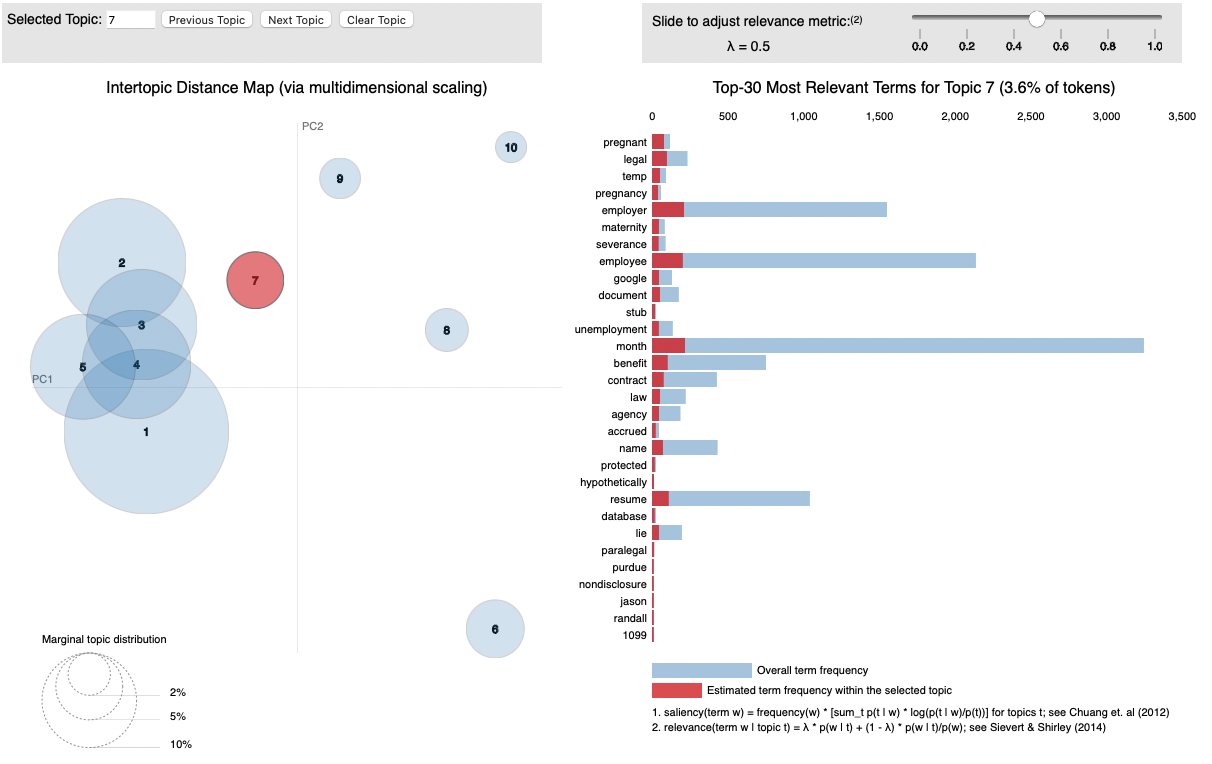